# 06__native_effects

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations 
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def is_ctrl(row):
    if "CONTROL" in row["index"]:
        return "control"
    else:
        return "TSS"

In [5]:
def cleaner_biotype(row, biotype_col):
    if row[biotype_col] in ["protein_coding", "div_pc"]:
        return "mRNA"
    elif row[biotype_col] == "intergenic":
        return "lincRNA"
    elif row[biotype_col] in ["antisense", "div_lnc"]:
        return "lncRNA"
    elif row[biotype_col] == "enhancer":
        return "eRNA"
    elif row[biotype_col] == "no cage activity":
        return "no CAGE activity"
    else:
        return "other"

In [6]:
def native_status(row):
    if row.fdr < 0.05:
        return "significant native effect"
    else:
        return "no native effect"

In [7]:
def native_status_detail(row):
    if row.fdr < 0.05:
        if row.logFC < 0:
            return "native effect\n(higher in human)"
        else:
            return "native effect\n(higher in mouse)"
    else:
        return "no native effect"

In [8]:
def biotype_switch(row):
    if row.biotype_hg19 == row.biotype_mm9:
        return row.biotype_hg19
    elif row.biotype_hg19 == "no cage activity" or row.biotype_mm9 == "no cage activity":
        return "CAGE turnover"
    else:
        return "biotype switch"

In [9]:
def biotype_switch_clean(row):
    if row.cleaner_biotype_hg19 == row.cleaner_biotype_mm9:
        return row.cleaner_biotype_hg19
    elif row.cleaner_biotype_hg19 == "no CAGE activity" or row.cleaner_biotype_mm9 == "no CAGE activity":
        return "CAGE turnover"
    else:
        return "biotype switch"

In [10]:
def native_status_complete(row):
    if row.fdr_native < 0.05:
        if row.logFC_native < 0:
            if row.mESC_padj_mm9 >= 0.05 and row.abs_logFC_native >= 2.5:
                return "native effect\n(complete gain in human)"
            else:
                return "native effect\n(partial gain in human)"
        else:
            if row.HUES64_padj_hg19 >= 0.05 and row.abs_logFC_native >= 2.5:
                return "native effect\n(complete gain in mouse)"
            else:
                return "native effect\n(partial gain in mouse)"
    else:
        return "no native effect"

## variables

In [11]:
data_dir = "../../../data/02__mpra/02__activs"
alpha_f = "%s/alpha_per_elem.quantification.txt" % data_dir
human_max_f = "%s/human_TSS_vals.max_tile.txt" % data_dir
mouse_max_f= "%s/mouse_TSS_vals.max_tile.txt" % data_dir

In [12]:
native_f = "%s/native_results.txt" % data_dir

In [13]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.UPDATED.txt"

## 1. import data

In [14]:
alpha = pd.read_table(alpha_f, sep="\t").reset_index()
alpha.head()

,index,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj
0,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...,2.307972,1.965289,6.836813e-66,3.296419e-24,1.196572e-64,4.966103e-23
1,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...,0.573923,0.485477,7.714719e-03,1.168301e-01,2.558485e-02,3.666646e-01
2,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...,0.315190,0.295362,4.085087e-01,4.806001e-01,6.631957e-01,7.220042e-01
3,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...,0.235547,0.177407,6.711073e-01,7.454044e-01,7.826055e-01,8.000145e-01
4,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...,0.431180,0.376351,1.124697e-01,2.962260e-01,2.746731e-01,6.347699e-01


In [15]:
human_max = pd.read_table(human_max_f)
mouse_max = pd.read_table(mouse_max_f)
human_max.head()

,element,tss_id,biotype_hg19,tss_tile_num,HUES64,HUES64_log,HUES64_padj,HUES64_sig,cleaner_biotype
0,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,1.848145e-02,sig,mRNA
1,GGGCGGGACGGAGACTCTGGGCTCAAGGCTCCTGGAAATGGGCGGG...,h.998,div_pc,tile2,0.885958,-0.052587,1.044316e-06,sig,mRNA
2,AAAAGGCAGTGCTTGATTCAATTCAACATTCACTGCGCCACTTACC...,h.997,div_pc,tile2,0.423129,-0.373527,2.996315e-01,not sig,mRNA
3,CGGAGGGGCGGGGCAAGAGTGGGAGGAGACCCTGCGCGCGGCCGCC...,h.996,div_pc,tile2,2.452145,0.389546,5.019212e-74,sig,mRNA
4,AGGGTGGTGCGTGGTCTACGGCGAGCGGAGTGGGGCGGGGTCGCGC...,h.995,div_pc,tile1,0.994045,-0.002594,6.400385e-09,sig,mRNA


In [16]:
native = pd.read_table(native_f).reset_index()
native.head()

,index,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
0,h.2__div_lnc__m.1__div_lnc,0.539205,0.462763,0.590123,1,14,5,4,-0.276289
1,h.3__div_lnc__m.2__antisense,17.144705,0.000035,0.000267,1,13,5,4,2.195646
2,h.4__antisense_upep__m.3__protein_coding,2.830974,0.092462,0.171542,1,14,5,4,-0.494120
3,h.5__intergenic__m.4__intergenic_upep,5.158088,0.023138,0.057673,1,14,5,4,0.593878
4,h.6__intergenic__m.4__intergenic_upep,4.795227,0.028539,0.068713,1,14,5,4,-0.563779


In [17]:
tss_map = pd.read_table(tss_map_f, index_col=0)
tss_map.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,avg_exp_hg19,avg_exp_mm9,stem_exp_hg19,stem_exp_mm9,har,orig_species,lift_species,oligo_type,hg19_id,mm9_id
0,chr1,2984981,2984982,-,"chr1:2984976..2984989,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,0.1,0.43,0.027777800000000002,0.0175,False,human,mouse,human__divergent:mouse__divergent,h.0,m.0
1,chr1,2985002,2985003,-,"chr1:2984997..2985037,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,0.29,0.43,0.0311111,0.0175,False,human,mouse,human__divergent:mouse__divergent,h.1,m.0
2,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,2.54,0.85,0.07111110000000001,0.0,False,human,mouse,human__divergent:mouse__divergent,h.2,m.1
3,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",div_lnc,ENSG00000238290.1,True,True,chr4,...,0.3,0.14,0.10444400000000001,0.0,False,human,mouse,human__divergent:mouse__antisense,h.3,m.2
4,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,0.19,0.25,0.03,0.0,False,human,mouse,human__antisense:mouse__protein_coding,h.4,m.3


## 2. plot native controls vs. TSSs

In [18]:
native["ctrl_status"] = native.apply(is_ctrl, axis=1)
native.sample(5)

,index,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC,ctrl_status
978,h.1107__div_pc__m.989__div_pc,1.616848,0.203532,0.313828,1,14,5,4,-0.287287,TSS
1147,h.1403__enhancer__m.1085__enhancer,2.997307,0.083403,0.158342,1,14,5,4,-0.734272,TSS
2168,h.2506__enhancer__m.2318__no cage activity,0.627410,0.428307,0.558378,1,13,5,4,0.395283,TSS
1575,h.1747__div_lnc__m.1559__no cage activity,5.979253,0.014475,0.039771,1,14,5,4,1.375795,TSS
239,h.290__div_lnc__m.186__div_lnc,5.820170,0.015843,0.042796,1,12,5,4,1.225116,TSS


In [19]:
native.ctrl_status.value_counts()

TSS        3279
control     400
Name: ctrl_status, dtype: int64

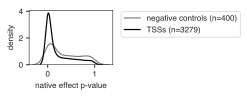

In [20]:
fig = plt.figure(figsize=(1.5, 1))
sns.distplot(native[native["ctrl_status"] == "control"]["pval"], hist=False, color="gray",
             label="negative controls (n=%s)" % len(native[native["ctrl_status"] == "control"]))
sns.distplot(native[native["ctrl_status"] != "control"]["pval"], hist=False, color="black",
             label="TSSs (n=%s)" % len(native[native["ctrl_status"] != "control"]))

plt.ylabel("density")
plt.xlabel("native effect p-value")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
fig.savefig("native_ctrl_pval_dist.pdf", dpi="figure", bbox_inches="tight")

In [21]:
native["abs_logFC"] = np.abs(native["logFC"])

In [22]:
order = ["control", "TSS"]
pal = {"control": "gray", "TSS": "black"}

1.0442639711e-51


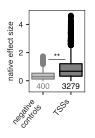

In [23]:
fig = plt.figure(figsize=(1, 1.5))
ax = sns.boxplot(data=native, x="ctrl_status", y="abs_logFC", flierprops = dict(marker='o', markersize=5), 
                 order=order, palette=pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["negative\ncontrols", "TSSs"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("native effect size")

for i, label in enumerate(order):
    n = len(native[native["ctrl_status"] == label])
    color = pal[label]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 5))

# calc p-vals b/w dists
dist1 = np.asarray(native[native["ctrl_status"] == "control"]["abs_logFC"])
dist2 = np.asarray(native[native["ctrl_status"] != "control"]["abs_logFC"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 1.5, 0, 1.4, pval, fontsize)
fig.savefig("native_ctrl_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

## 3. classify native effects

In [24]:
native["native_status"] = native.apply(native_status, axis=1)
native["native_status_detail"] = native.apply(native_status_detail, axis=1)
native.native_status_detail.value_counts()

no native effect                    2254
native effect\n(higher in mouse)     825
native effect\n(higher in human)     600
Name: native_status_detail, dtype: int64

## 4. merge alphas & native effects w/ TSS pair map

In [25]:
tss_map["cleaner_biotype_hg19"] = tss_map.apply(cleaner_biotype, biotype_col="biotype_hg19", axis=1)
tss_map["cleaner_biotype_mm9"] = tss_map.apply(cleaner_biotype, biotype_col="biotype_mm9", axis=1)
tss_map.sample(5)

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,stem_exp_hg19,stem_exp_mm9,har,orig_species,lift_species,oligo_type,hg19_id,mm9_id,cleaner_biotype_hg19,cleaner_biotype_mm9
1265,chr2,232545792,232545793,-,chr2:232545684-232546083,enhancer,chr2:232545684-232546083__NEGATIVE,True,True,chr1,...,5.38057,2.96739,False,human,mouse,human__enhancer:mouse__enhancer,h.1144,m.1016,eRNA,eRNA
1167,chr4,87517085,87517086,+,no cage activity,no cage activity,no cage activity,True,False,chr5,...,no cage activity,0.0313543,False,mouse,human,human__no_CAGE:mouse__enhancer,h.3587,m.3397,no CAGE activity,eRNA
1348,chr12,91775350,91775351,+,chr12:91775053-91775433,enhancer,chr12:91775053-91775433__POSITIVE,True,True,chr10,...,0.20415999999999998,0.0297305,False,human,mouse,human__enhancer:mouse__enhancer,h.1350,m.1216,eRNA,eRNA
2031,chr15,75747434,75747435,+,chr15:75747348-75747533,enhancer,chr15:75747348-75747533__POSITIVE,True,True,chr9,...,0.7771100000000001,0.0922741,False,human,mouse,human__enhancer:mouse__enhancer,h.1511,m.1326,eRNA,eRNA
252,chr11,129873115,129873116,+,no cage activity,no cage activity,no cage activity,True,False,chr9,...,no cage activity,1.23125,False,mouse,human,human__no_CAGE:mouse__divergent,h.2830,m.2641,no CAGE activity,lncRNA


In [26]:
tss_map["biotype_switch"] = tss_map.apply(biotype_switch, axis=1)
tss_map.biotype_switch.value_counts()

CAGE turnover      2440
enhancer            854
biotype switch      781
protein_coding      261
div_pc              170
div_lnc              66
unassigned           34
intergenic           27
antisense            20
intergenic_upep      19
antisense_upep        9
div_upep              5
Name: biotype_switch, dtype: int64

In [27]:
tss_map["biotype_switch_clean"] = tss_map.apply(biotype_switch_clean, axis=1)
tss_map.biotype_switch_clean.value_counts()

CAGE turnover     2440
eRNA               854
mRNA               685
biotype switch     499
lncRNA             105
other               76
lincRNA             27
Name: biotype_switch_clean, dtype: int64

In [28]:
human_max_sub = human_max[["element", "tss_id"]]
human_max_sub.columns = ["hg19_element", "hg19_id"]

mouse_max_sub = mouse_max[["element", "tss_id"]]
mouse_max_sub.columns = ["mm9_element", "mm9_id"]
mouse_max_sub.sample(5)

,mm9_element,mm9_id
320,ACCGGCCGAACTCCGCGCTACGGTCCATGAGCGAGCGAGCGAGCTG...,m.681
2529,GGCGGGACCCCGGGCAGCGTCAGTGCCCCAGTCAGCACCCCCGGGT...,m.1706
545,CCTGGCAGTCAGGTTCTCCGGTGATGCGAAGTCCTCTGGCCAACCT...,m.457
723,CCAGGCTGTGGAATCCGGCTGCCAGGCGGGTCTGGGCCTGAACTAG...,m.3435
1717,TTTTTCTCCTTCCAGTTTATTACAGCCGTCGGCAGACCCTCAACGT...,m.2489


In [29]:
tss_map = tss_map.merge(human_max_sub, on="hg19_id").merge(mouse_max_sub, on="mm9_id")
print(len(tss_map))
tss_map.sample(5)

4140


,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,lift_species,oligo_type,hg19_id,mm9_id,cleaner_biotype_hg19,cleaner_biotype_mm9,biotype_switch,biotype_switch_clean,hg19_element,mm9_element
2407,chr14,104689932,104689933,+,"chr14:104689918..104689935,+",intergenic,ENSG00000258913.1,True,False,chr12,...,mouse,human__intergenic:mouse__no_CAGE,h.2208,m.2020,lincRNA,no CAGE activity,CAGE turnover,CAGE turnover,GGTGACCTTGGACACGGCGTAGCTGCCTGGGCCACCCCCTTTCCTT...,CCCGTTCATATCCTGACCCCTGACCCGGAACTGCTCACCCAACTCT...
470,chr18,76738854,76738855,-,"chr18:76738848..76738890,-",intergenic,ENSG00000263146.2,True,True,chr18,...,mouse,human__intergenic:mouse__enhancer,h.458,m.3475,lincRNA,eRNA,biotype switch,biotype switch,GGCCCACCCTTTCCCGGGATTTCGGGGATGACACGGGGGCCAGGTG...,CAGGCAAAAATAAGAAATTTAAGAAGAAAAAATTAACACACATGCA...
2063,chr2,227664061,227664062,+,"chr2:227664039..227664065,+",div_lnc,ENSG00000272622.1,True,False,chr1,...,mouse,human__divergent:mouse__no_CAGE,h.1813,m.1625,lncRNA,no CAGE activity,CAGE turnover,CAGE turnover,GTTGCCAAGTCCCAACGTTGCACGGGGTTCTCCCTCCTCCTTCGCC...,CGTTGCACCGGGTTCTCCCTCCTCCTTCTCCTCCTCCTCCTCTGCC...
1345,chr22,37428873,37428874,-,chr22:37428831-37429188,enhancer,chr22:37428831-37429188__NEGATIVE,True,True,chr15,...,mouse,human__enhancer:mouse__enhancer,h.1213,m.1085,eRNA,eRNA,enhancer,eRNA,GTTGGGTAGGGCGGGCCCTGGCAGAGGCCAGGATCCTGCAGTCAGT...,AGGCTAAGGCTGGGGGAGGGTAGCTCTACAGTGCCCGAGGCAGGGA...
3506,chr12,70424778,70424779,+,no cage activity,no cage activity,no cage activity,True,False,chr10,...,human,human__no_CAGE:mouse__intergenic,h.3138,m.2949,no CAGE activity,other,CAGE turnover,CAGE turnover,AAATAGATTTTTCCTAGAGCTCCTTGATCAAATAATCAGACCCACT...,AAAGACAGACAATCTGGTCTAAAGAGTCCTTCACAGTGTGTGTGGG...


In [30]:
tss_map = tss_map.merge(alpha, 
                        left_on="hg19_element", 
                        right_on="index").merge(alpha,
                                                left_on="mm9_element",
                                                right_on="index",
                                                suffixes=("_hg19", "_mm9"))

In [31]:
native["hg19_id"] = native["index"].str.split("__", expand=True)[0]
native["biotype_hg19"] = native["index"].str.split("__", expand=True)[1]
native["mm9_id"] = native["index"].str.split("__", expand=True)[2]
native["biotype_mm9"] = native["index"].str.split("__", expand=True)[3]
native.head()

,index,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC,ctrl_status,abs_logFC,native_status,native_status_detail,hg19_id,biotype_hg19,mm9_id,biotype_mm9
0,h.2__div_lnc__m.1__div_lnc,0.539205,0.462763,0.590123,1,14,5,4,-0.276289,TSS,0.276289,no native effect,no native effect,h.2,div_lnc,m.1,div_lnc
1,h.3__div_lnc__m.2__antisense,17.144705,0.000035,0.000267,1,13,5,4,2.195646,TSS,2.195646,significant native effect,native effect\n(higher in mouse),h.3,div_lnc,m.2,antisense
2,h.4__antisense_upep__m.3__protein_coding,2.830974,0.092462,0.171542,1,14,5,4,-0.494120,TSS,0.494120,no native effect,no native effect,h.4,antisense_upep,m.3,protein_coding
3,h.5__intergenic__m.4__intergenic_upep,5.158088,0.023138,0.057673,1,14,5,4,0.593878,TSS,0.593878,no native effect,no native effect,h.5,intergenic,m.4,intergenic_upep
4,h.6__intergenic__m.4__intergenic_upep,4.795227,0.028539,0.068713,1,14,5,4,-0.563779,TSS,0.563779,no native effect,no native effect,h.6,intergenic,m.4,intergenic_upep


In [32]:
native_sub = native[["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9", "fdr", "logFC", "abs_logFC",
                     "native_status", "native_status_detail"]]
native_sub.columns = ["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9", "fdr_native", "logFC_native", 
                      "abs_logFC_native", "native_status", "native_status_detail"]

In [33]:
tmp = tss_map.merge(native_sub, 
                    left_on=["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9"], 
                    right_on=["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9"])
data = tmp.drop(["index_hg19", "index_mm9"], axis=1)
print(len(data))
data = data.drop(["orig_species", "lift_species"], axis=1).drop_duplicates()
print(len(data))

# found one annoying duplicate because the expr values has a bunch of zeroes on the end for one enhancer
# just ignore this one by keeping first guy automatically since they are the same
data = data.drop_duplicates(subset=["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9"])
print(len(data))
data.sample(5)

4140
3280
3279


,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,mESC_mm9,HUES64_pval_mm9,mESC_pval_mm9,HUES64_padj_mm9,mESC_padj_mm9,fdr_native,logFC_native,abs_logFC_native,native_status,native_status_detail
2198,chr2,177502716,177502717,-,"chr2:177502703..177502747,-",div_lnc,ENSG00000163364.5,True,False,chr2,...,0.420582,4.257541e-01,0.211551,6.758596e-01,0.540765,0.009668,1.317872,1.317872,significant native effect,native effect\n(higher in mouse)
1806,chrX,106917423,106917424,-,chrX:106917022-106917635,enhancer,chrX:106917022-106917635__NEGATIVE,True,True,chrX,...,0.278393,5.542167e-01,0.521259,7.407933e-01,0.734016,0.565614,-0.246725,0.246725,no native effect,no native effect
1170,chr5,133802579,133802580,-,chr5:133802349-133802592,enhancer,chr5:133802349-133802592__NEGATIVE,True,True,chr11,...,0.341495,3.428494e-01,0.372270,6.033993e-01,0.682271,0.000348,1.433708,1.433708,significant native effect,native effect\n(higher in mouse)
1666,chr19,59049729,59049730,-,chr19:59049687-59049971,enhancer,chr19:59049687-59049971__NEGATIVE,True,True,chr7,...,0.738303,1.461582e-14,0.003363,9.875996e-14,0.017489,0.096856,0.746519,0.746519,no native effect,no native effect
3531,chr1,65533019,65533020,-,no cage activity,no cage activity,no cage activity,True,False,chr4,...,0.334000,1.171500e-03,0.389426,4.330025e-03,0.693376,0.256993,-0.843139,0.843139,no native effect,no native effect


## 5. plot native effects on scatter plot

In [34]:
len(data)

3279

In [35]:
# limit to those that are significant in at least 1 context
data_filt = data[(data["HUES64_padj_hg19"] < 0.05) | (data["mESC_padj_mm9"] < 0.05)]
len(data_filt)

1832

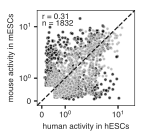

In [36]:
fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

not_sig = data_filt[data_filt["fdr_native"] >= 0.01]
sig = data_filt[data_filt["fdr_native"] < 0.01]

ax.scatter(sig["HUES64_hg19"], sig["mESC_mm9"], s=10, alpha=0.75, 
           color="black", linewidths=0.5, edgecolors="white")
ax.scatter(not_sig["HUES64_hg19"], not_sig["mESC_mm9"], s=8, alpha=0.5, 
           color="gray", linewidths=0.5, edgecolors="white")

plt.xlabel("human activity in hESCs")
plt.ylabel("mouse activity in mESCs")
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.2, 25], [-0.2, 25], linestyle="dashed", color="k")
ax.set_xlim((-0.2, 25))
ax.set_ylim((-0.2, 25))

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["HUES64_hg19"])) & 
                   (~pd.isnull(data_filt["mESC_mm9"]))]
r, p = spearmanr(no_nan["HUES64_hg19"], no_nan["mESC_mm9"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(data_filt)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("native_scatter.pdf", dpi="figure", bbox_inches="tight")

3.44939098415e-113
0.119591489737


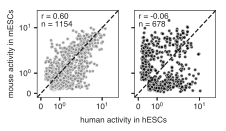

In [37]:
fig, axarr = plt.subplots(figsize=(3.2, 1.6), nrows=1, ncols=2, sharex=True, sharey=True)

for i in [0, 1]:
    ax = axarr[i]
    
    if i == 0:
        sub = data_filt[data_filt["fdr_native"] >= 0.01]
        color = "gray"
        ax.set_ylabel("mouse activity in mESCs")
    else:
        sub = data_filt[data_filt["fdr_native"] < 0.01]
        color = "black"
        ax.set_ylabel("")

    ax.scatter(sub["HUES64_hg19"], sub["mESC_mm9"], s=10, alpha=0.75, 
               color=color, linewidths=0.5, edgecolors="white")
    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    
    ax.plot([-0.2, 30], [-0.2, 30], linestyle="dashed", color="k")
    ax.set_xlim((-0.2, 30))
    ax.set_ylim((-0.2, 30))
    
    # annotate corr
    no_nan = sub[(~pd.isnull(sub["HUES64_hg19"])) & 
                 (~pd.isnull(sub["mESC_mm9"]))]
    r, p = spearmanr(no_nan["HUES64_hg19"], no_nan["mESC_mm9"])
    print(p)
    ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
            transform=ax.transAxes)
    ax.text(0.05, 0.88, "n = %s" % (len(sub)), ha="left", va="top", fontsize=fontsize,
            transform=ax.transAxes)

plt.text(0.5, -0.075, "human activity in hESCs", ha="center", va="center", transform=plt.gcf().transFigure,
         fontsize=fontsize)
fig.savefig("native_scatter_human.separated.pdf", dpi="figure", bbox_inches="tight")

## 6. plot native effect sizes across biotypes

In [38]:
clean_order = ["eRNA", "lincRNA", "lncRNA", "mRNA"]

0.569989138254
0.239790539885
0.596369971088


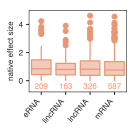

In [39]:
fig = plt.figure(figsize=(1.75, 1.5))
ax = sns.boxplot(data=data_filt, x="cleaner_biotype_hg19", y="abs_logFC_native", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=clean_order, color=sns.color_palette("Set2")[1])
mimic_r_boxplot(ax)

ax.set_xticklabels(clean_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("native effect size")

for i, label in enumerate(clean_order):
    n = len(data_filt[data_filt["cleaner_biotype_hg19"] == label])
    color = sns.color_palette("Set2")[1]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 5))

# calc p-vals b/w dists
dist1 = np.asarray(data_filt[data_filt["cleaner_biotype_hg19"] == "eRNA"]["abs_logFC_native"])
dist2 = np.asarray(data_filt[data_filt["cleaner_biotype_hg19"] == "lncRNA"]["abs_logFC_native"])
dist3 = np.asarray(data_filt[data_filt["cleaner_biotype_hg19"] == "mRNA"]["abs_logFC_native"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]

u12, pval12 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval12)

u13, pval13 = stats.mannwhitneyu(dist1, dist3, alternative="two-sided", use_continuity=False)
print(pval13)

u23, pval23 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
print(pval23)

# annotate_pval(ax, 0.2, 0.8, 1.65, 0, 1.64, pval12, fontsize)
# annotate_pval(ax, 1.2, 1.8, 1.65, 0, 1.64, pval23, fontsize)
# annotate_pval(ax, 0.2, 1.8, 2.2, 0, 2.19, pval13, fontsize)

fig.savefig("native_clean_biotype_hg19_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [40]:
full_order = ["enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
full_labels = ["eRNA", "lincRNA", "div. lncRNA", "mRNA", "div. mRNA"]

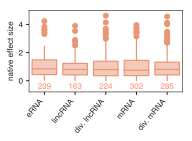

In [41]:
fig = plt.figure(figsize=(2.75, 1.5))
ax = sns.boxplot(data=data_filt, x="biotype_hg19", y="abs_logFC_native", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=full_order, color=sns.color_palette("Set2")[1])
mimic_r_boxplot(ax)

ax.set_xticklabels(full_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("native effect size")

for i, label in enumerate(full_order):
    n = len(data_filt[data_filt["biotype_hg19"] == label])
    color = sns.color_palette("Set2")[1]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 5))

fig.savefig("native_biotype_hg19_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

0.32662542446
0.0165699241566
0.260614926367


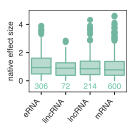

In [42]:
fig = plt.figure(figsize=(1.75, 1.5))
ax = sns.boxplot(data=data_filt, x="cleaner_biotype_mm9", y="abs_logFC_native", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=clean_order, color=sns.color_palette("Set2")[0])
mimic_r_boxplot(ax)

ax.set_xticklabels(clean_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("native effect size")

for i, label in enumerate(clean_order):
    n = len(data_filt[data_filt["cleaner_biotype_mm9"] == label])
    color = sns.color_palette("Set2")[0]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 5))

# calc p-vals b/w dists
dist1 = np.asarray(data_filt[data_filt["cleaner_biotype_mm9"] == "eRNA"]["abs_logFC_native"])
dist2 = np.asarray(data_filt[data_filt["cleaner_biotype_mm9"] == "lncRNA"]["abs_logFC_native"])
dist3 = np.asarray(data_filt[data_filt["cleaner_biotype_mm9"] == "mRNA"]["abs_logFC_native"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]

u12, pval12 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval12)

u13, pval13 = stats.mannwhitneyu(dist1, dist3, alternative="two-sided", use_continuity=False)
print(pval13)

u23, pval23 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
print(pval23)

# annotate_pval(ax, 0.2, 0.8, 1.65, 0, 1.64, pval12, fontsize)
# annotate_pval(ax, 1.2, 1.8, 1.65, 0, 1.64, pval23, fontsize)
# annotate_pval(ax, 0.2, 1.8, 2.2, 0, 2.19, pval13, fontsize)

fig.savefig("native_clean_biotype_mm9_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

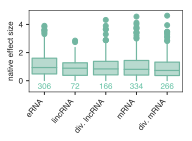

In [43]:
fig = plt.figure(figsize=(2.75, 1.5))
ax = sns.boxplot(data=data_filt, x="biotype_mm9", y="abs_logFC_native", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=full_order, color=sns.color_palette("Set2")[0])
mimic_r_boxplot(ax)

ax.set_xticklabels(full_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("native effect size")

for i, label in enumerate(full_order):
    n = len(data_filt[data_filt["biotype_mm9"] == label])
    color = sns.color_palette("Set2")[0]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 5))

fig.savefig("native_biotype_mm9_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [44]:
switch_order = ["CAGE turnover", "eRNA", "lincRNA", "lncRNA", "mRNA"]

0.928610154922
0.539017899105
0.814691254307


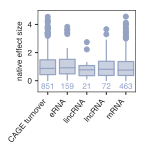

In [45]:
fig = plt.figure(figsize=(1.75, 1.5))
ax = sns.boxplot(data=data_filt, x="biotype_switch_clean", y="abs_logFC_native", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=switch_order, color=sns.color_palette("Set2")[2])
mimic_r_boxplot(ax)

ax.set_xticklabels(switch_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("native effect size")

for i, label in enumerate(switch_order):
    n = len(data_filt[data_filt["biotype_switch_clean"] == label])
    color = sns.color_palette("Set2")[2]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 5))

# calc p-vals b/w dists
dist1 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "CAGE turnover"]["abs_logFC_native"])
dist2 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "eRNA"]["abs_logFC_native"])
dist3 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "lncRNA"]["abs_logFC_native"])
dist4 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "mRNA"]["abs_logFC_native"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]
dist4 = dist4[~np.isnan(dist4)]

u12, pval12 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval12)

u23, pval23 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
print(pval23)

u34, pval34 = stats.mannwhitneyu(dist3, dist4, alternative="two-sided", use_continuity=False)
print(pval34)

# annotate_pval(ax, 0.2, 0.8, 1.75, 0, 1.74, pval12, fontsize)
# annotate_pval(ax, 1.2, 1.8, 1.75, 0, 1.74, pval23, fontsize)
# annotate_pval(ax, 2.2, 2.8, 1.75, 0, 1.75, pval34, fontsize)

fig.savefig("native_clean_biotype_switch_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [46]:
full_switch_order = ["CAGE turnover", "enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
full_switch_labels = ["CAGE turnover", "eRNA", "lincRNA", "div. lncRNA", "mRNA", "div. mRNA"]

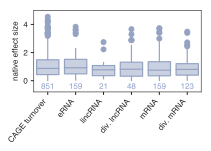

In [47]:
fig = plt.figure(figsize=(3, 1.5))
ax = sns.boxplot(data=data_filt, x="biotype_switch", y="abs_logFC_native", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=full_switch_order, color=sns.color_palette("Set2")[2])
mimic_r_boxplot(ax)

ax.set_xticklabels(full_switch_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("native effect size")

for i, label in enumerate(full_switch_order):
    n = len(data_filt[data_filt["biotype_switch"] == label])
    color = sns.color_palette("Set2")[2]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 5))

# # calc p-vals b/w dists
# dist1 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "CAGE turnover"]["abs_logFC_native"])
# dist2 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "eRNA"]["abs_logFC_native"])
# dist3 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "lncRNA"]["abs_logFC_native"])
# dist4 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "mRNA"]["abs_logFC_native"])

# dist1 = dist1[~np.isnan(dist1)]
# dist2 = dist2[~np.isnan(dist2)]
# dist3 = dist3[~np.isnan(dist3)]
# dist4 = dist4[~np.isnan(dist4)]

# u12, pval12 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
# print(pval12)

# u23, pval23 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
# print(pval23)

# u34, pval34 = stats.mannwhitneyu(dist3, dist4, alternative="two-sided", use_continuity=False)
# print(pval34)

# annotate_pval(ax, 0.2, 0.8, 1.75, 0, 1.74, pval12, fontsize)
# annotate_pval(ax, 1.2, 1.8, 1.75, 0, 1.74, pval23, fontsize)
# annotate_pval(ax, 2.2, 2.8, 1.75, 0, 1.75, pval34, fontsize)

fig.savefig("native_biotype_switch_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

## 7. find % of TSSs that have significant effects across biotypes

In [48]:
tots = data_filt.groupby("biotype_switch")["hg19_id"].agg("count").reset_index()
sig = data_filt[data_filt["native_status"] != "no native effect"].groupby("biotype_switch")["hg19_id"].agg("count").reset_index()
full_sig = tots.merge(sig, on="biotype_switch", how="left").fillna(0)
full_sig["percent_sig"] = (full_sig["hg19_id_y"]/full_sig["hg19_id_x"])*100
full_sig.head()

,biotype_switch,hg19_id_x,hg19_id_y,percent_sig
0,CAGE turnover,851,439,51.586369
1,antisense,8,5,62.500000
2,antisense_upep,6,3,50.000000
3,biotype switch,437,196,44.851259
4,div_lnc,48,24,50.000000


In [49]:
# get a hypergeometric p-value for each biotype
res = {}

tot_genes = np.sum(full_sig["hg19_id_x"])
tot_native = np.sum(full_sig["hg19_id_y"])
for biotype in full_switch_order:
    row = full_sig[full_sig["biotype_switch"] == biotype].iloc[0]
    n_biotype = row.hg19_id_x
    n_native = row.hg19_id_y
    
    pval = stats.hypergeom.sf(n_native-1, tot_genes, n_biotype, tot_native)
    res[biotype] = {"pval": pval}
    
res = pd.DataFrame.from_dict(res, orient="index").reset_index()
full_sig = full_sig.merge(res, left_on="biotype_switch", right_on="index")
full_sig["padj"] = multicomp.multipletests(full_sig["pval"], method="fdr_bh")[1]
full_sig.head()

,biotype_switch,hg19_id_x,hg19_id_y,percent_sig,index,pval,padj
0,CAGE turnover,851,439,51.586369,CAGE turnover,0.049126,0.211367
1,div_lnc,48,24,50.000000,div_lnc,0.527505,0.802805
2,div_pc,123,59,47.967480,div_pc,0.667983,0.802805
3,enhancer,159,88,55.345912,enhancer,0.070456,0.211367
4,intergenic,21,9,42.857143,intergenic,0.795642,0.802805


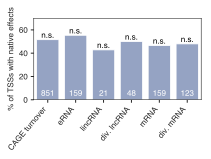

In [50]:
fig = plt.figure(figsize=(3, 1.5))
ax = sns.barplot(data=full_sig, x="biotype_switch", y="percent_sig", 
                 order=full_switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(full_switch_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of TSSs with native effects")

for i, label in enumerate(full_switch_order):
    n = full_sig[full_sig["biotype_switch"] == label]["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)

    p_sig = full_sig[full_sig["biotype_switch"] == label]["percent_sig"].iloc[0]
    fdr = full_sig[full_sig["biotype_switch"] == label]["padj"].iloc[0]
    if fdr < 0.01:
        txt = "**"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    elif fdr < 0.05:
        txt = "*"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    else:
        txt = "n.s."
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, 0.25), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=fontsize)

ax.set_ylim((0, 70))

fig.savefig("perc_sig_native_biotype_switch.pdf", dpi="figure", bbox_inches="tight")

In [51]:
tots = data_filt.groupby("biotype_switch_clean")["hg19_id"].agg("count").reset_index()
sig = data_filt[data_filt["native_status"] != "no native effect"].groupby("biotype_switch_clean")["hg19_id"].agg("count").reset_index()
clean_sig = tots.merge(sig, on="biotype_switch_clean", how="left").fillna(0)
clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
clean_sig.head()

,biotype_switch_clean,hg19_id_x,hg19_id_y,percent_sig
0,CAGE turnover,851,439,51.586369
1,biotype switch,234,108,46.153846
2,eRNA,159,88,55.345912
3,lincRNA,21,9,42.857143
4,lncRNA,72,37,51.388889


In [52]:
# get a fisher's exact p-value for each biotype
res = {}

tot_genes = np.sum(clean_sig["hg19_id_x"])
tot_native = np.sum(clean_sig["hg19_id_y"])
for biotype in switch_order:
    row = clean_sig[clean_sig["biotype_switch_clean"] == biotype].iloc[0]
    n_biotype = row.hg19_id_x
    n_native = row.hg19_id_y
    
    pval = stats.hypergeom.sf(n_native-1, tot_genes, n_biotype, tot_native)
    res[biotype] = {"pval": pval}
    
res = pd.DataFrame.from_dict(res, orient="index").reset_index()
clean_sig = clean_sig.merge(res, left_on="biotype_switch_clean", right_on="index")
clean_sig["padj"] = multicomp.multipletests(clean_sig["pval"], method="fdr_bh")[1]
clean_sig.head()

,biotype_switch_clean,hg19_id_x,hg19_id_y,percent_sig,index,pval,padj
0,CAGE turnover,851,439,51.586369,CAGE turnover,0.049126,0.176139
1,eRNA,159,88,55.345912,eRNA,0.070456,0.176139
2,lincRNA,21,9,42.857143,lincRNA,0.795642,0.969917
3,lncRNA,72,37,51.388889,lncRNA,0.414913,0.691522
4,mRNA,463,212,45.788337,mRNA,0.969917,0.969917


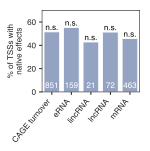

In [53]:
fig = plt.figure(figsize=(1.75, 1.5))
ax = sns.barplot(data=clean_sig, x="biotype_switch_clean", y="percent_sig", 
                 order=switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(switch_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of TSSs with\nnative effects")

for i, label in enumerate(switch_order):
    n = clean_sig[clean_sig["biotype_switch_clean"] == label]["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
    
    p_sig = clean_sig[clean_sig["biotype_switch_clean"] == label]["percent_sig"].iloc[0]
    fdr = clean_sig[clean_sig["biotype_switch_clean"] == label]["padj"].iloc[0]
    if fdr < 0.01:
        txt = "**"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    elif fdr < 0.05:
        txt = "*"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    else:
        txt = "n.s."
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, 0.25), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=fontsize)

ax.set_ylim((0, 70))

fig.savefig("perc_sig_native_clean_biotype_switch.pdf", dpi="figure", bbox_inches="tight")

## 8. look into complete v. partial native gains/losses

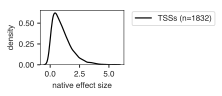

In [54]:
fig = plt.figure(figsize=(1.5, 1))
sns.distplot(data_filt["abs_logFC_native"], hist=False, color="black",
             label="TSSs (n=%s)" % len(data_filt))

plt.ylabel("density")
plt.xlabel("native effect size")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
fig.savefig("native_effectsize_dist.pdf", dpi="figure", bbox_inches="tight")

(-0.2, 25)

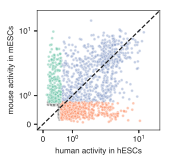

In [55]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

sig_human_only = data_filt[(data_filt["HUES64_padj_hg19"] < 0.01) & (data_filt["mESC_padj_mm9"] >= 0.01)]
sig_mouse_only = data_filt[(data_filt["HUES64_padj_hg19"] >= 0.01) & (data_filt["mESC_padj_mm9"] < 0.01)]
sig_both = data_filt[(data_filt["HUES64_padj_hg19"] < 0.01) & (data_filt["mESC_padj_mm9"] < 0.01)]
sig_neither = data_filt[(data_filt["HUES64_padj_hg19"] >= 0.01) & (data_filt["mESC_padj_mm9"] >= 0.01)]

ax.scatter(sig_neither["HUES64_hg19"], sig_neither["mESC_mm9"], s=10, alpha=0.75, 
           color="gray", linewidths=0.5, edgecolors="white")
ax.scatter(sig_both["HUES64_hg19"], sig_both["mESC_mm9"], s=8, alpha=0.5, 
           color=sns.color_palette("Set2")[2], linewidths=0.5, edgecolors="white")
ax.scatter(sig_human_only["HUES64_hg19"], sig_human_only["mESC_mm9"], s=8, alpha=0.5, 
           color=sns.color_palette("Set2")[1], linewidths=0.5, edgecolors="white")
ax.scatter(sig_mouse_only["HUES64_hg19"], sig_mouse_only["mESC_mm9"], s=8, alpha=0.5, 
           color=sns.color_palette("Set2")[0], linewidths=0.5, edgecolors="white")

plt.xlabel("human activity in hESCs")
plt.ylabel("mouse activity in mESCs")
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.2, 25], [-0.2, 25], linestyle="dashed", color="k")
ax.set_xlim((-0.2, 25))
ax.set_ylim((-0.2, 25))

# # annotate corr
# no_nan = data_filt[(~pd.isnull(data_filt["HUES64_hg19"])) & 
#                    (~pd.isnull(data_filt["mESC_mm9"]))]
# r, p = spearmanr(no_nan["HUES64_hg19"], no_nan["mESC_mm9"])
# ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
#         transform=ax.transAxes)
# ax.text(0.05, 0.90, "n = %s" % (len(data_filt)), ha="left", va="top", fontsize=fontsize,
#         transform=ax.transAxes)
# fig.savefig("native_scatter.pdf", dpi="figure", bbox_inches="tight")

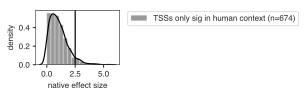

In [56]:
fig = plt.figure(figsize=(1.5, 1))
sns.distplot(sig_human_only["abs_logFC_native"], hist=True, bins=15, color="black",
             label="TSSs only sig in human context (n=%s)" % len(sig_human_only))

plt.ylabel("density")
plt.xlabel("native effect size")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
plt.axvline(x=2.5, color="black", zorder=1)
#fig.savefig("native_effectsize_dist.pdf", dpi="figure", bbox_inches="tight")

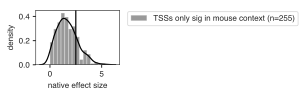

In [57]:
fig = plt.figure(figsize=(1.5, 1))
sns.distplot(sig_mouse_only["abs_logFC_native"], hist=True, bins=15, color="black",
             label="TSSs only sig in mouse context (n=%s)" % len(sig_mouse_only))

plt.ylabel("density")
plt.xlabel("native effect size")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
plt.axvline(x=2.5, color="black", zorder=1)
#fig.savefig("native_effectsize_dist.pdf", dpi="figure", bbox_inches="tight")

use an effect size cut-off of 2.5 as this roughly corresponds to the shoulder in both contexts

In [58]:
data["native_status_complete"] = data.apply(native_status_complete, axis=1)
data_filt = data[(data["HUES64_padj_hg19"] < 0.05) | (data["mESC_padj_mm9"] < 0.05)]
data_filt.native_status_complete.value_counts()

no native effect                           926
native effect\n(partial gain in mouse)     433
native effect\n(partial gain in human)     397
native effect\n(complete gain in mouse)     43
native effect\n(complete gain in human)     33
Name: native_status_complete, dtype: int64

In [59]:
data_filt.native_status.value_counts()

no native effect             926
significant native effect    906
Name: native_status, dtype: int64

In [60]:
native_order = ["no native effect", "significant native effect"]
native_pal = {"no native effect": "gray", "significant native effect": "black"}

det_order = ["native effect\n(higher in human)", "native effect\n(higher in mouse)"]
complete_pal = {"native effect\n(higher in human)": sns.color_palette("Set2")[1],
                "native effect\n(higher in mouse)": sns.color_palette("Set2")[0]}
det_pal = {"native effect\n(higher in human)": sns.light_palette(sns.color_palette("Set2")[1])[2],
           "native effect\n(higher in mouse)": sns.light_palette(sns.color_palette("Set2")[0])[2]}

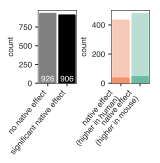

In [61]:
fig, axarr = plt.subplots(figsize=(2, 1.34), nrows=1, ncols=2)

ax1 = axarr[0]
sns.countplot(data=data_filt, x="native_status", palette=native_pal, order=native_order, linewidth=2, 
              edgecolor=native_pal.values(), ax=ax1)
ax1.set_xticklabels(native_order, va="top", ha="right", rotation=50)
ax1.set_xlabel("")

for i, label in enumerate(native_order):
    n = len(data_filt[data_filt["native_status"] == label])
    ax1.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)

ax2 = axarr[1]
sns.countplot(data=data_filt, x="native_status_detail", palette=det_pal, order=det_order, linewidth=2, 
              edgecolor=det_pal.values(), ax=ax2)

# now add the complete gains stacked bar part
sub = data_filt[data_filt["native_status_complete"].str.contains("complete")]
sns.countplot(data=sub, x="native_status_detail", order=det_order, palette=complete_pal, linewidth=2, 
              edgecolor=complete_pal.values(), ax=ax2)
ax2.set_xticklabels(det_order, va="top", ha="right", rotation=50)
ax2.set_xlabel("")
ax2.set_ylabel("count")

plt.subplots_adjust(wspace=0.9)
fig.savefig("count_native_status.filt.complete_v_partial.pdf", dpi="figure", bbox_inches="tight")

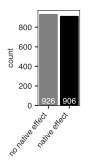

In [62]:
fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

sns.countplot(data=data_filt, x="native_status", palette=native_pal, order=native_order, linewidth=2, 
              edgecolor=native_pal.values(), ax=ax)
ax.set_xticklabels(["no native effect", "native effect"], va="top", ha="right", rotation=50)
ax.set_xlabel("")

for i, label in enumerate(native_order):
    n = len(data_filt[data_filt["native_status"] == label])
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)

fig.savefig("count_native_status.filt.sig_status.pdf", dpi="figure", bbox_inches="tight")

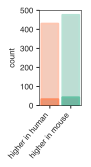

In [63]:
fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

sns.countplot(data=data_filt, x="native_status_detail", palette=det_pal, order=det_order, linewidth=2, 
              edgecolor=det_pal.values(), ax=ax)

# now add the complete gains stacked bar part
sub = data_filt[data_filt["native_status_complete"].str.contains("complete")]
sns.countplot(data=sub, x="native_status_detail", order=det_order, palette=complete_pal, linewidth=2, 
              edgecolor=complete_pal.values(), ax=ax)
ax.set_xticklabels(["higher in human", "higher in mouse"], va="top", ha="right", rotation=50)
ax.set_xlabel("")
ax.set_ylabel("count")
fig.savefig("count_native_status.filt.complete_status.pdf", dpi="figure", bbox_inches="tight")

In [64]:
complete = data_filt[data_filt["native_status_complete"].str.contains("complete")].groupby("biotype_switch_clean")["hg19_id"].agg("count").reset_index()
clean_sig_comp = clean_sig.merge(complete, on="biotype_switch_clean", how="left").fillna(0)
clean_sig_comp["percent_complete"] = (clean_sig_comp["hg19_id"]/clean_sig_comp["hg19_id_x"])*100
clean_sig_comp.head()

,biotype_switch_clean,hg19_id_x,hg19_id_y,percent_sig,index,pval,padj,hg19_id,percent_complete
0,CAGE turnover,851,439,51.586369,CAGE turnover,0.049126,0.176139,38,4.465335
1,eRNA,159,88,55.345912,eRNA,0.070456,0.176139,5,3.144654
2,lincRNA,21,9,42.857143,lincRNA,0.795642,0.969917,1,4.761905
3,lncRNA,72,37,51.388889,lncRNA,0.414913,0.691522,1,1.388889
4,mRNA,463,212,45.788337,mRNA,0.969917,0.969917,20,4.319654


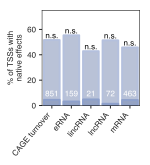

In [65]:
fig = plt.figure(figsize=(1.75, 1.75))
ax = sns.barplot(data=clean_sig_comp, x="biotype_switch_clean", y="percent_sig", 
                 order=switch_order, color=sns.light_palette(sns.color_palette("Set2")[2])[3], 
                 linewidth=2, edgecolor=sns.light_palette(sns.color_palette("Set2")[2])[3])

# now add the complete gains stacked bar part
sns.barplot(data=clean_sig_comp, x="biotype_switch_clean", y="percent_complete", order=switch_order, 
            color=sns.color_palette("Set2")[2], 
            linewidth=2, edgecolor=sns.color_palette("Set2")[2], ax=ax)

ax.set_xticklabels(switch_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of TSSs with\nnative effects")

for i, label in enumerate(switch_order):
    n = clean_sig_comp[clean_sig_comp["biotype_switch_clean"] == label]["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 6), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
    
    p_sig = clean_sig_comp[clean_sig_comp["biotype_switch_clean"] == label]["percent_sig"].iloc[0]
    fdr = clean_sig_comp[clean_sig_comp["biotype_switch_clean"] == label]["padj"].iloc[0]
    if fdr < 0.01:
        txt = "**"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    elif fdr < 0.05:
        txt = "*"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    else:
        txt = "n.s."
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, 0.25), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=fontsize)

ax.set_ylim((0, 75))

fig.savefig("perc_sig_native_clean_biotype_switch.with_complete.pdf", dpi="figure", bbox_inches="tight")

## 9. write results file

In [66]:
results_dir = "../../../data/02__mpra/03__results"

In [67]:
data.to_csv("%s/native_effects_data.txt" % results_dir, sep="\t", index=False)